Ref: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

In [1]:
from __future__ import division
import time

# Import data
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('data_dir', '/tmp/data/', 'Directory for storing data')

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score
import numpy as np

In [3]:
sess = tf.InteractiveSession()

In [4]:
mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Standard Neural Network

In [126]:
class StandardNeuralNet:
    # 2 layers hidden unit
    def __init__(self, h=800, epoch=100, learning_rate=0.5, batch_size=100, activate_f='sigmoid'):
        self.h = h
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activate_f = activate_f
        self.W1 = None
        self.W2 = None
        self.W3 = None
        self.b1 = None
        self.b2 = None
        self.b3 = None
    
    def fit(self, train):
        batch_X, batch_y = train.next_batch(self.batch_size)
        d = batch_X.shape[1]
        c = batch_y.shape[1]

        tf_X = tf.placeholder(tf.float32, [None, d])
        tf_y = tf.placeholder(tf.float32, [None, c])
        W1 = tf.Variable(tf.random_normal([d, self.h], seed=1)/d)
        b1 = tf.Variable(tf.zeros(self.h))
        W2 = tf.Variable(tf.random_normal([self.h, self.h], seed=1)/self.h)
        b2 = tf.Variable(tf.zeros(self.h))
        W3 = tf.Variable(tf.random_normal([self.h, c], seed=1)/self.h)
        b3 = tf.Variable(tf.zeros(c))

        z1 = tf.matmul(tf_X, W1) + b1
        a1 = self.activation_func(z1)
        z2 = tf.matmul(a1, W2) + b2
        a2 = self.activation_func(z2)
        z3 = tf.matmul(a2, W3) + b3

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z3, tf_y))
        train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(cross_entropy)

        sess.run(tf.initialize_variables([W1, b1, W2, b2, W3, b3]))
        for i in range(self.epoch):
            if i != 0:
                batch_X, batch_y = train.next_batch(self.batch_size)
            start_time = time.time()
            sess.run(train_step, feed_dict={tf_X: batch_X, tf_y: batch_y})
            if ((i+1) % (self.epoch / 10) == 0):
                print "Epoch %d: %fs. Loss: %f" % (i+1, time.time()-start_time, sess.run(cross_entropy, feed_dict={
                    tf_X: batch_X, tf_y: batch_y
                }))

        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
        self.W3 = W3
        self.b3 = b3

    def predict(self, X):
        tf_X = tf.placeholder(tf.float32, [None, X.shape[1]])
        z1 = tf.matmul(tf_X, self.W1) + self.b1
        a1 = self.activation_func(z1)
        z2 = tf.matmul(a1, self.W2) + self.b2
        a2 = self.activation_func(z2)
        z3 = tf.matmul(a2, self.W3) + self.b3
        y_hat = tf.nn.softmax(z3)

        return sess.run(y_hat, feed_dict={tf_X: X})
    
    def activation_func(self, tensor):
        if self.activate_f == 'sigmoid':
            return tf.sigmoid(tensor)
        elif self.activate_f == 'relu':
            return tf.nn.relu(tensor)
        else:
            return tf.sigmoid(tensor)

In [140]:
nn = StandardNeuralNet(epoch=50000, batch_size=100, learning_rate=0.5)
start_time = time.time()
nn.fit(mnist.train)
print time.time() - start_time

Epoch 5000: 0.006167s. Loss: 0.461452
Epoch 10000: 0.006259s. Loss: 0.054473
Epoch 15000: 0.007211s. Loss: 0.057508
Epoch 20000: 0.006778s. Loss: 0.025488
Epoch 25000: 0.006331s. Loss: 0.019770
Epoch 30000: 0.006856s. Loss: 0.012587
Epoch 35000: 0.006383s. Loss: 0.008531
Epoch 40000: 0.006463s. Loss: 0.005894
Epoch 45000: 0.006796s. Loss: 0.001172
Epoch 50000: 0.007322s. Loss: 0.004672
356.73375392


In [141]:
y_hat = nn.predict(mnist.test.images)
accuracy_score(np.argmax(mnist.test.labels, 1), np.argmax(y_hat, 1))

0.98089999999999999

In [142]:
print 'W1 weight sum: ', sess.run(tf.reduce_sum(tf.abs(nn.W1)))
print 'b1 weight sum: ', sess.run(tf.reduce_sum(tf.abs(nn.b1)))
print 'W2 weight sum: ', sess.run(tf.reduce_sum(tf.abs(nn.W2)))
print 'b2 weight sum: ', sess.run(tf.reduce_sum(tf.abs(nn.b2)))
print 'W3 weight sum: ', sess.run(tf.reduce_sum(tf.abs(nn.W3)))
print 'b3 weight sum: ', sess.run(tf.reduce_sum(tf.abs(nn.b3)))

W1 weight sum:  19316.9
b1 weight sum:  134.357
W2 weight sum:  10502.4
b2 weight sum:  32.0134
W3 weight sum:  1476.93
b3 weight sum:  40.3481


## Dropout Neural Network

In [143]:
class DropoutNeuralNet:
    def __init__(self, h=800, epoch=100, learning_rate=0.5,
                 batch_size=100, input_keep_prob=0.8, unit_keep_prob=0.5, activate_f='sigmoid'):
        self.h = h
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_keep_prob = input_keep_prob
        self.unit_keep_prob = unit_keep_prob
        self.activate_f = activate_f
        self.W1 = None
        self.W2 = None
        self.W3 = None
        self.b1 = None
        self.b2 = None
        self.b3 = None
    
    def fit(self, train):
        batch_X, batch_y = train.next_batch(self.batch_size)
        d = batch_X.shape[1]
        c = batch_y.shape[1]

        tf_X = tf.placeholder(tf.float32, [None, d])
        tf_y = tf.placeholder(tf.float32, [None, c])
        W1 = tf.Variable(tf.random_normal([d, self.h], seed=1)/d)
        b1 = tf.Variable(tf.zeros(self.h))
        W2 = tf.Variable(tf.random_normal([self.h, self.h], seed=1)/self.h)
        b2 = tf.Variable(tf.zeros(self.h))
        W3 = tf.Variable(tf.random_normal([self.h, c], seed=1)/self.h)
        b3 = tf.Variable(tf.zeros(c))

        tf_input_keep_prob = tf.placeholder(tf.float32)
        tf_unit_keep_prob = tf.placeholder(tf.float32)
        z1 = tf.matmul(tf.nn.dropout(tf_X, tf_input_keep_prob), W1) + b1
        a1 = self.activation_func(z1)
        z2 = tf.matmul(tf.nn.dropout(a1, tf_unit_keep_prob), W2) + b2
        a2 = self.activation_func(z2)
        z3 = tf.matmul(tf.nn.dropout(a2, tf_unit_keep_prob), W3) + b3

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z3, tf_y))
        train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(cross_entropy)

        sess.run(tf.initialize_variables([W1, b1, W2, b2, W3, b3]))
        for i in range(self.epoch):
            if i != 0:
                batch_X, batch_y = train.next_batch(self.batch_size)
            start_time = time.time()
            sess.run(train_step, feed_dict={
                tf_X: batch_X, tf_y: batch_y,
                tf_input_keep_prob: self.input_keep_prob, tf_unit_keep_prob: self.unit_keep_prob
            })
            if ((i+1) % (self.epoch / 10) == 0):
                print "Epoch %d: %fs. Loss: %f" % (i+1, time.time()-start_time, sess.run(cross_entropy, feed_dict={
                    tf_X: batch_X, tf_y: batch_y,
                    tf_input_keep_prob: 1.0, tf_unit_keep_prob: 1.0
                }))

        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
        self.W3 = W3
        self.b3 = b3

    def predict(self, X):
        tf_X = tf.placeholder(tf.float32, [None, X.shape[1]])
        z1 = tf.matmul(tf_X, self.W1) + self.b1
        a1 = self.activation_func(z1)
        z2 = tf.matmul(a1, self.W2) + self.b2
        a2 = self.activation_func(z2)
        z3 = tf.matmul(a2, self.W3) + self.b3
        y_hat = tf.nn.softmax(z3)

        return sess.run(y_hat, feed_dict={tf_X: X})

    def activation_func(self, tensor):
        if self.activate_f == 'sigmoid':
            return tf.sigmoid(tensor)
        elif self.activate_f == 'relu':
            return tf.nn.relu(tensor)
        else:
            return tf.sigmoid(tensor)

In [144]:
dnn = DropoutNeuralNet(epoch=50000, batch_size=100, learning_rate=0.5, input_keep_prob=0.8, unit_keep_prob=0.5)
start_time = time.time()
dnn.fit(mnist.train)
print time.time() - start_time

Epoch 5000: 0.007720s. Loss: 0.184990
Epoch 10000: 0.007865s. Loss: 0.238144
Epoch 15000: 0.013736s. Loss: 0.084782
Epoch 20000: 0.009580s. Loss: 0.073746
Epoch 25000: 0.007992s. Loss: 0.051901
Epoch 30000: 0.007717s. Loss: 0.088258
Epoch 35000: 0.007728s. Loss: 0.031086
Epoch 40000: 0.008247s. Loss: 0.013410
Epoch 45000: 0.007742s. Loss: 0.010903
Epoch 50000: 0.007803s. Loss: 0.035912
434.356910229


In [145]:
y_hat = dnn.predict(mnist.test.images)
accuracy_score(np.argmax(mnist.test.labels, 1), np.argmax(y_hat, 1))

0.98119999999999996

In [148]:
print 'W1 weight sum: ', sess.run(tf.reduce_sum(tf.abs(dnn.W1)))
print 'b1 weight sum: ', sess.run(tf.reduce_sum(tf.abs(dnn.b1)))
print 'W2 weight sum: ', sess.run(tf.reduce_sum(tf.abs(dnn.W2)))
print 'b2 weight sum: ', sess.run(tf.reduce_sum(tf.abs(dnn.b2)))
print 'W3 weight sum: ', sess.run(tf.reduce_sum(tf.abs(dnn.W3)))
print 'b3 weight sum: ', sess.run(tf.reduce_sum(tf.abs(dnn.b3)))

W1 weight sum:  29328.1
b1 weight sum:  366.19
W2 weight sum:  26359.1
b2 weight sum:  62.7144
W3 weight sum:  1524.89
b3 weight sum:  25.0907


### Use network size of n/p

In [164]:
scaled_dnn = DropoutNeuralNet(epoch=50000, h=1600, batch_size=100, learning_rate=0.5, input_keep_prob=0.8, unit_keep_prob=0.5)
start_time = time.time()
scaled_dnn.fit(mnist.train)
print time.time() - start_time

Epoch 5000: 0.018034s. Loss: 0.192051
Epoch 10000: 0.018018s. Loss: 0.113749
Epoch 15000: 0.016975s. Loss: 0.116774
Epoch 20000: 0.018545s. Loss: 0.124080
Epoch 25000: 0.016843s. Loss: 0.044140
Epoch 30000: 0.016844s. Loss: 0.113981
Epoch 35000: 0.017273s. Loss: 0.021266
Epoch 40000: 0.016759s. Loss: 0.016683
Epoch 45000: 0.016838s. Loss: 0.013646
Epoch 50000: 0.017110s. Loss: 0.007922
887.836215973


In [165]:
y_hat = scaled_dnn.predict(mnist.test.images)
accuracy_score(np.argmax(mnist.test.labels, 1), np.argmax(y_hat, 1))

0.98080000000000001

## Effect on Features

In [161]:
plt.rc('image', cmap='gray')
def plot_image(gray_scale):
    two_dim = int(np.sqrt(gray_scale.shape[0])) # Find the dimension of the 2D matrix
    image = np.reshape(gray_scale, (two_dim, two_dim))
    # reverse gray scale because 0 represents white instead of black
    plt.imshow(np.ones(image.shape)-image)
    plt.axis('off')

def plot_first_layer_grid(w):
    sample_unit_size = 784
    plt.figure(figsize =(8,8))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, unit_i in enumerate(xrange(sample_unit_size)):
        p = plt.subplot(28, 28, i+1)
        plot_image(w[:,unit_i])

In [150]:
standard_W1 = sess.run(nn.W1)
dropout_W1 = sess.run(dnn.W1)

### Standard

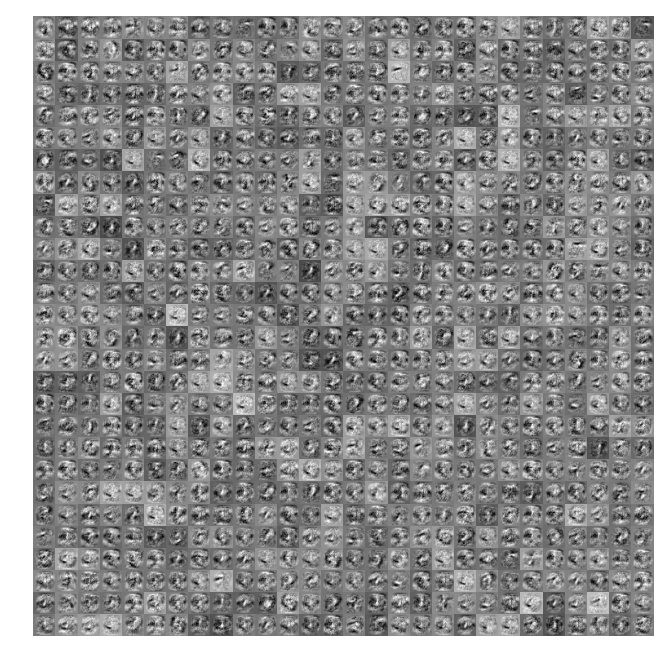

In [162]:
plot_first_layer_grid(standard_W1)

### Dropout

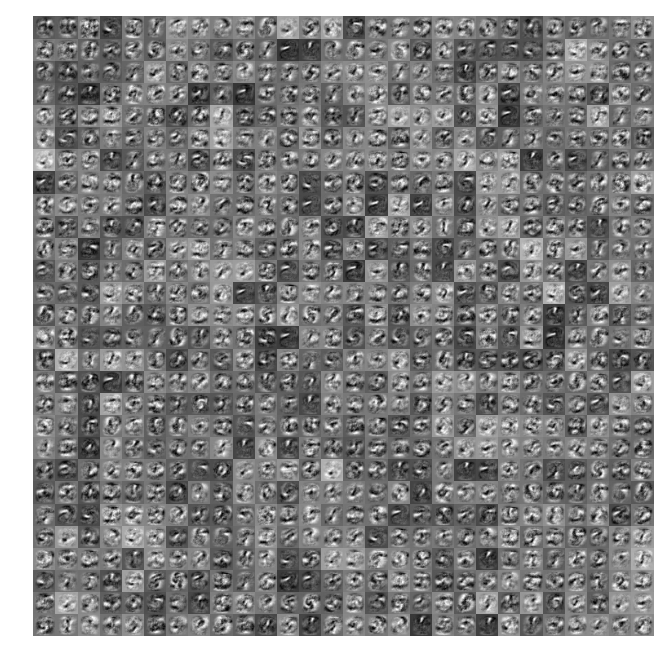

In [163]:
plot_first_layer_grid(dropout_W1)

## Observation

Although, standard nerual network has lower loss during training compared to the dropout neural network, standard neural network actually overfits the training data set and therfore has lower accuracy when evaluating on the test data.

In standard neural network, since every hidden unit is fully connected to the units in the previous layer, the parameter is updated based on how other units are doing. Therefore, it tends to fix up the mistakes of other units and results in co-adaptations which is the cause of overfitting because co-adaptations do not generalize unseen data.

On the other hand, dropout prevents co-adaptations by making hidden unit unreliable and thus each unit has to learn its own mistakes. As can be seen in the figures above, the first layer in the standard neural network does not seem to learn any meaningful feature. The features co-adapt in order to produce good reconsturction. Conversely, the first layer in the dropout neural network seems to be able to learn meaning featurs such as strokes, edges and different spots of the images. The color contrast is also much higher (therefore more confident) than the standard one. We can even see the layer out of some of the digits.